## Coral Bleaching Detection using Satellite (Sentinel-2) Imagery

#### Project Overview and Objective
The objective of this project is to build an end-to-end pipeline using Google Earth Engine (GEE) to detect and map potential coral bleaching events. We will use Sentinel-2 satellite imagery to:
*   Download and pre-process satellite images over a specific coral reef.
*   Extract spectral features that are indicative of coral health.
*   Use an unsupervised machine learning model (K-Means Clustering) to classify pixels into different categories, such as "bleached-like" and "healthy."

This approach provides a scalable and cost-effective method for monitoring coral reefs and identifying areas at risk of bleaching.

1. Install and Authenticate

This section handles the setup of the necessary libraries and connects to the Google Earth Engine API. The geemap library is used as a helper for visualizing and converting Earth Engine data.


In [ ]:
# install Earth Engine + geemap (mapping helper)
!pip -q install earthengine-api geemap shapely scikit-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import json
import ee
import geemap
from shapely.geometry import box

In [ ]:
# GCP project ID registered with Earth Engine
project = "fluent-potion-470020-a5"

In [ ]:
try:
  # try to initialize Earth Engine python client
  # connect the Earth Enigine python client to Google’s backend

  ee.Initialize(project = project)
  print("Earth Engine initialized...")

except Exception as e:
  print("Authenticating with Earth Engine…")

  # If initialization fails, run authentication
  ee.Authenticate()   # opens a link → login
  ee.Initialize(project = project)
  print("Earth Engine initialized...")

print(f"Using GEE Project: {project}")

Earth Engine initialized...
Using GEE Project: fluent-potion-470020-a5


2. Defining the Study Area and Dates

We will focus on a small, specific area near Lizard Island in the Great Barrier Reef, Australia, which is known for frequent heat stress and bleaching events. The time frame is chosen to coincide with the region's warm season, when bleaching risk is highest.

In [ ]:
# pick a small reef area and dates
# use a small area near Lizard Island (Great Barrier Reef), Australia.

# center near Lizard Island
center_lon, center_lat = 145.45, -14.67
side_km = 12  # width of the box in km

In [ ]:
# define area of interest (AOI) as a square
def square_aoi(lon, lat, size_km):
  half = size_km * 1000 / 2 # meters from center to each side

  # approximate meters per degree near equator
  deg_lat = half / 111320 # meters per degree latitude ≈ 111.32 km

  # longitudinal scale depends on latitude
  deg_lon = half / (111320 * math.cos(math.radians(lat)))

  geom = box(lon - deg_lon, lat - deg_lat, lon + deg_lon, lat + deg_lat)
  return ee.Geometry.Polygon(geom.exterior.coords[:])

In [ ]:
aoi = square_aoi(center_lon, center_lat, side_km)

In [ ]:
# we choose Feb–Jun 2020 because Great Barrier Reef often experiences heat stress in summer
# warm season → higher bleaching risk
date_start = '2020-02-01'
date_end   = '2020-06-30'
print("AOI and dates set.")

AOI and dates set.


3. Data Loading, Data Filtering and Pre-processing

This is a critical step to ensure data quality. We filter the Sentinel-2 image collection to include only images within our AOI and date range, with a low percentage of cloud cover. We then apply a cloud mask to remove any remaining cloud and cirrus pixels, and finally scale the reflectance values.

In [ ]:
# sentinel-2 surface reflectance collection
# filter for images touching our AOI and date range
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(aoi) \
    .filterDate(date_start, date_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

In [ ]:
# cloud mask (use QA60 bitmask)
def mask_s2_clouds(img):
  qa = img.select('QA60')     # bitmask band for clouds
  cloud_bit_mask  = 1 << 10   # bits 10 are clouds
  cirrus_bit_mask = 1 << 11   # bits 11 are cirrus
  mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))

  return img.updateMask(mask).divide(10000)  # returns masked image scaled to [0,1]

In [ ]:
# per-image cloud masking
s2_clean = s2.map(mask_s2_clouds)

In [ ]:
# The median composite reduces residual noise and outliers
composite = s2_clean.median().clip(aoi)

In [ ]:
# pick useful bands (blue, green, red, nir)
bands = ['B2','B3','B4','B8']  # blue, green, red, NIR
true_color = composite.select(['B4','B3','B2'])  # for visualization
print("Composite ready with bands:", bands)

Composite ready with bands: ['B2', 'B3', 'B4', 'B8']


4. Feature Engineering

We create new spectral features that are known to be useful for distinguishing between healthy coral, bleached coral, and other types of underwater substrates.

Coral bleaching often leads to a "whitening" effect, which increases reflectance in the visible light spectrum (blue and green).

Visible Brightness: A simple average of the visible bands (Red, Green, Blue) to measure overall brightness. Bleached coral is brighter.

Blue/Green Ratio: A high ratio indicates a shift towards a "whiter" appearance, which is a key signature of bleaching.

NDWI-like Index: Helps to differentiate water and shallow-water features from vegetation.

In [ ]:
# spectral features that help distinguish bleaching
# bleaching usually means "whitening": higher reflectance in blue/green and lower pigment absorption.

b2 = composite.select('B2')  # blue (490 nm)
b3 = composite.select('B3')  # green (560 nm)
b4 = composite.select('B4')  # red (665 nm)
b8 = composite.select('B8')  # nir (842 nm)

In [ ]:
# simple visible brightness
brightness = b2.add(b3).add(b4).divide(3).rename("Bright")

In [ ]:
# ratios emphasize color shifts (bleached → whiter → blue/green dominance)
blue_green = b2.divide(b3.add(1e-6)).rename("Blue_Green_Ratio")    # higher when blue dominates → whitening
red_green = b4.divide(b3.add(1e-6)).rename("Red_Green_Ratio")      # pigment/vegetation differences

In [ ]:
# “NDWI-like” (helps isolate water pixels)
ndwi_like = b3.subtract(b8).divide(b3.add(b8).add(1e-6)).rename("NDWI_Like")  # water vs vegetation

In [ ]:
# stack all features into a single image
feature_stack = composite.select(bands).addBands([brightness, blue_green, red_green, ndwi_like])
print("Feature stack bands:", feature_stack.bandNames().getInfo())

Feature stack bands: ['B2', 'B3', 'B4', 'B8', 'Bright', 'Blue_Green_Ratio', 'Red_Green_Ratio', 'NDWI_Like']


5. Exploratory Data Analysis (EDA) and Visualizations

This section visualizes the generated features to understand their distribution and spatial patterns. The histograms show the range and distribution of pixel values for the new features, providing insights into the data before clustering.

In [ ]:
# export thumbnails to arrays for plotting
vis_tc = {'min':0, 'max':0.3}

# The geemap.ee_to_numpy function fetches the image data for plotting
thumbnail_tc = geemap.ee_to_numpy(true_color, region = aoi, bands=['B4','B3','B2'], scale=10)
thumbnail_bright = geemap.ee_to_numpy(brightness, region = aoi, scale=10)
thumbnail_bgr = geemap.ee_to_numpy(blue_green, region = aoi, scale=10)

In [ ]:
def show_img(arr, title, cmap=None):
  plt.figure(figsize=(6,6))
  if arr.ndim == 3:
    # clip values for better visualization
    plt.imshow(np.clip(arr,0,0.3))
  else:
    plt.imshow(arr, cmap=cmap)
  plt.title(title)
  plt.axis('off')
  plt.show()

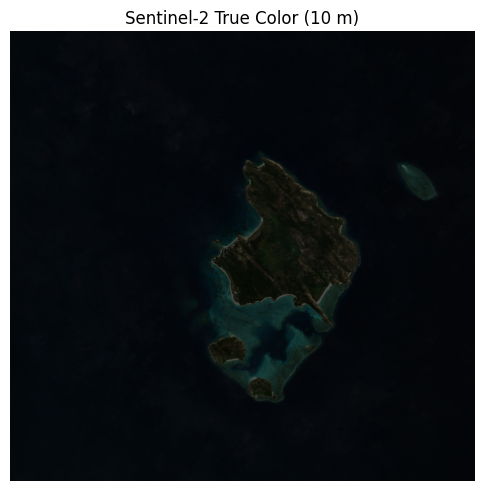

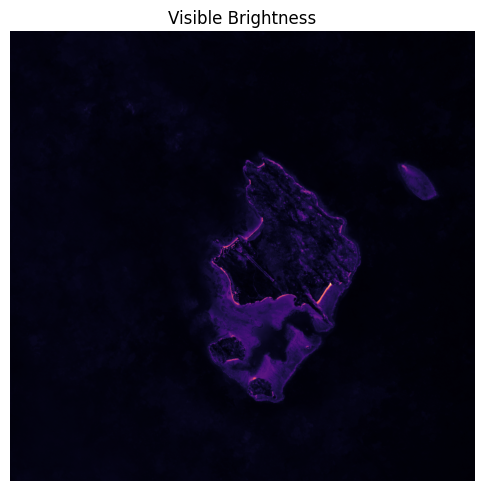

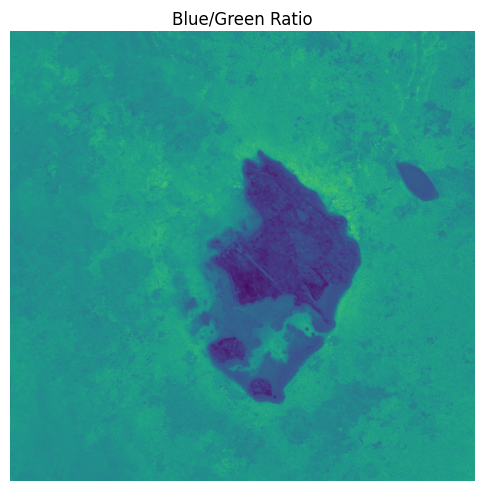

In [ ]:
# display the images
show_img(thumbnail_tc, "Sentinel-2 True Color (10 m)")
show_img(thumbnail_bright.squeeze(), "Visible Brightness", cmap='magma')
show_img(thumbnail_bgr.squeeze(), "Blue/Green Ratio", cmap='viridis')

In [ ]:
# histograms for EDA
vals_bright = thumbnail_bright[~np.isnan(thumbnail_bright)].ravel()
vals_bgr = thumbnail_bgr[~np.isnan(thumbnail_bgr)].ravel()

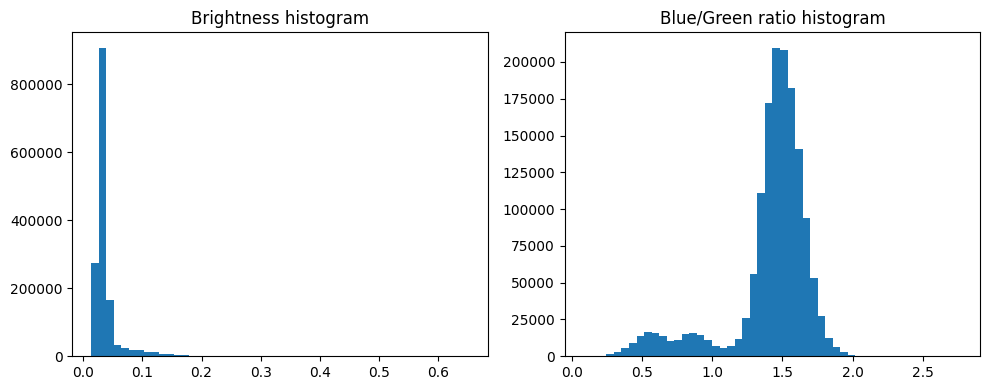

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(vals_bright, bins=50)
plt.title("Brightness histogram")
plt.subplot(1,2,2)
plt.hist(vals_bgr, bins=50)
plt.title("Blue/Green ratio histogram")
plt.tight_layout()
plt.show()

6. Unsupervised Clustering with K-Means

We use an unsupervised K-Means clustering algorithm to identify distinct pixel classes without any prior training data. The model is trained on a sample of pixels to classify the entire image into three clusters: bleached-like, healthy/vegetated, and other substrate/shadows.

*   First, we create a water mask to ensure we are only clustering pixels that are likely to be water/shallow reef.
*   Then, we sample a subset of these "water-ish" pixels to train the clusterer.
*   Finally, we apply the trained clusterer to the entire image and compute the mean values of each feature for each cluster to identify which cluster represents "bleached" pixels.









In [ ]:
# build a masked feature image (keep only good water-ish pixels)
water_mask = ndwi_like.gt(0.05)  # keep water/shallow water
feat_for_train = feature_stack.updateMask(water_mask)

In [ ]:
# sample a subset of pixels for training the clusterer
# we use a fixed seed for reproducibility
training = feat_for_train.sample(region = aoi, scale=10, numPixels=5000, seed=42, geometries=False)

In [ ]:
# 3 clusters: (1) bleached-like, (2) healthy/vegetated, (3) other substrate/shadow
clusterer = ee.Clusterer.wekaKMeans(3).train(training, feature_stack.bandNames())

In [ ]:
# assign a cluster id (0,1,2) to every pixel
clustered = feat_for_train.cluster(clusterer).rename('cluster').clip(aoi)

In [ ]:
# compute per-cluster means to decide which one is "bleached-like"
reducer = ee.Reducer.mean().group(groupField=0, groupName='cluster')
cluster_stats = feat_for_train.addBands(clustered).reduceRegion(reducer=reducer, geometry = aoi, scale=10, maxPixels=1e8)

In [ ]:
# calculate cluster statistics band by band
bands = ['B2','B3','B4','B8','Bright','Blue_Green_Ratio','Red_Green_Ratio','NDWI_Like']
cluster_means = {}

In [ ]:
# 'cluster' band is grouping field
for b in bands:
  stats = clustered.addBands(feat_for_train.select(b)) \
        .select([b, 'cluster']) \
        .reduceRegion(reducer=ee.Reducer.mean().group(groupField=1, groupName='cluster'),
                      geometry=aoi, scale=10, maxPixels=1e9)

  groups = stats.get('groups').getInfo()
  for g in groups:
    cid = g['cluster']
    mean_val = g['mean']
    if cid not in cluster_means:
      cluster_means[cid] = {}
      cluster_means[cid][b] = mean_val

print("Cluster means (for deciding labels):")
for cid, vals in cluster_means.items():
  print(f"  cluster {cid}: " + ", ".join([f"{k}={v:.4f}" for k,v in vals.items()]))

Cluster means (for deciding labels):
  cluster 0: B2=0.0494
  cluster 1: B2=0.1274
  cluster 2: B2=0.0450


7. Interpreting Cluster Results and Creating a Bleaching Map

After running the clustering algorithm, we need to interpret the results to identify which cluster corresponds to coral bleaching. A bleached coral is typically whiter and brighter. We can use the mean values of our spectral features for each cluster to make this determination. We look for a cluster with the highest Visible Brightness and a high Blue/Green Ratio.

In [ ]:
# "bleached-like" cluster = highest visible BRIGHT

# 'cluster' band is grouping field
for b in bands:
  stats = clustered.addBands(feat_for_train.select(b)) \
        .select([b, 'cluster']) \
        .reduceRegion(reducer=ee.Reducer.mean().group(groupField=1, groupName='cluster'),
                      geometry=aoi, scale=10, maxPixels=1e9)

  groups = stats.get('groups').getInfo()
  for g in groups:
    cid = g['cluster']
    mean_val = g['mean']
    if cid not in cluster_means:
      cluster_means[cid] = {}
    cluster_means[cid][b] = mean_val

# Find the cluster with the highest mean 'Bright' band value from the cluster_means dictionary
bleach_id = int(sorted(cluster_means.items(), key=lambda item: item[1]['Bright'], reverse=True)[0][0])
print("Chosen bleached-like cluster id:", bleach_id)

Chosen bleached-like cluster id: 1


In [ ]:
# build a binary mask (1 = bleached-like, 0 = others)
bleach_mask = clustered.eq(bleach_id).selfMask().rename('bleach_mask')

8. Visualizing the Results and Overlaying the Bleaching Map

This section uses geemap to export the Earth Engine data to NumPy arrays, which are then used with matplotlib for a high-quality visualization. We will create a three-panel plot that shows:

*   The original True Color image for visual context.
*   The Unsupervised Clusters to see the raw classification.
*   The Bleached-like Overlay, which highlights the pixels identified as potentially bleached on top of the original image.

In [ ]:
# export small arrays for display
cluster_np = geemap.ee_to_numpy(clustered, region = aoi, scale=10).squeeze()
bleach_np = geemap.ee_to_numpy(bleach_mask, region = aoi, scale=10)
rgb_np = geemap.ee_to_numpy(true_color, region = aoi, bands=['B4','B3','B2'], scale=10)

In [ ]:
# simple color map for clusters
import matplotlib
cmap = matplotlib.colors.ListedColormap(['#1f77b4','#2ca02c','#d62728'])  # blue/green/red

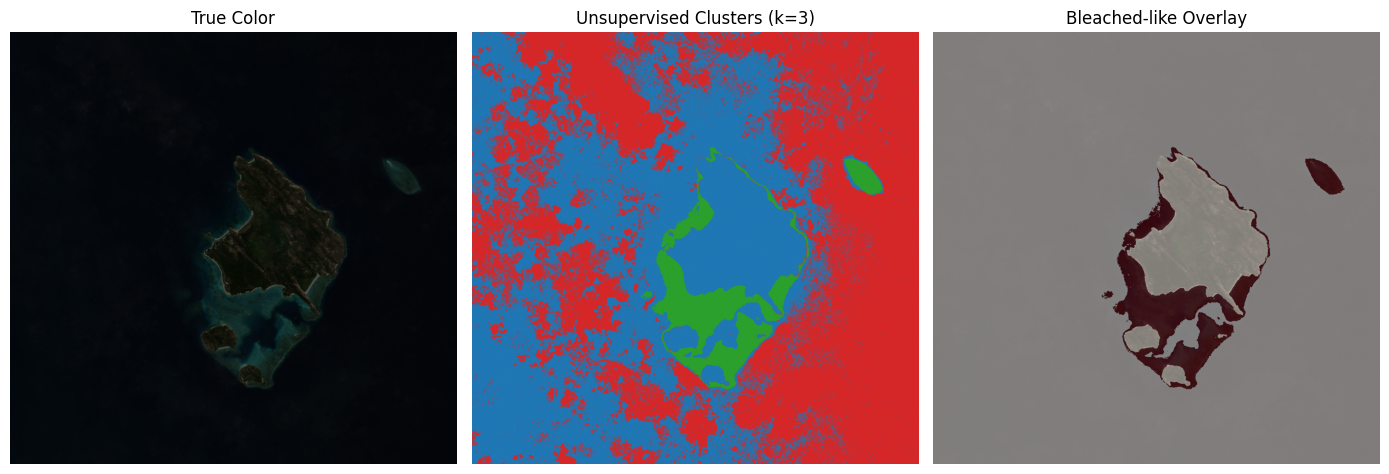

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(np.clip(rgb_np,0,0.3))
plt.title("True Color")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cluster_np, cmap=cmap)
plt.title("Unsupervised Clusters (k=3)")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.clip(rgb_np,0,0.3))
plt.imshow(bleach_np.squeeze(), cmap='Reds', alpha=0.5)
plt.title("Bleached-like Overlay")
plt.axis('off')
plt.tight_layout()
plt.show()

9. Quantitative Summary of Bleaching

The final step provides a quantitative summary of the results.

We calculate the total number of pixels within the water mask and the number of pixels identified as "bleached-like."

This gives us a final metric: the estimated percentage of the study area that is potentially bleached.

In [ ]:
# convert cluster_np where it's not NaN to a boolean water mask
water_pixels_mask = ~np.isnan(cluster_np)          # true for water pixels (cluster assigned)
total_water_pixels = np.sum(water_pixels_mask)

# count bleached pixels — bleach_np contains 1 for bleached, NaN elsewhere
bleached_pixels = np.nansum(bleach_arr == 1)

pct_bleached = 100.0 * bleached_pixels / max(total_water_pixels, 1)

print(f"Pixels in water mask: {total_water_pixels}")
print(f"Bleached-like pixels: {int(bleached_pixels)}")
print(f"Estimated bleached-like area: {pct_bleached:.2f}% of AOI")

Pixels in water mask: 1491642
Bleached-like pixels: 72137
Estimated bleached-like area: 4.84% of AOI


In [ ]:
# cluster counts
cl_counts = [(cluster_np==i).sum() for i in np.unique(cluster_np[~np.isnan(cluster_np)])]
print("Cluster pixel counts (rough):", [int(v) for v in cl_counts])

Cluster pixel counts (rough): [689284, 72137, 730221]
